<h1>1. Import the libraries</h1>

In [1]:
# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Sklearn - Preprocessing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Sklearn - Model Selection & Validation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.inspection import permutation_importance

# Sklearn - Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

# Sklearn - Models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.dummy import DummyClassifier


# Imbalanced-learn - Oversampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # sklearn yerine

# Optional Plot Style
plt.style.use('default')
sns.set_palette("viridis")


<h1>2. Data and feature sets</h1>

In [2]:
dataset = "./2025 08 26_DF extended.xlsx"
df = pd.read_excel(dataset, header=0)  

In [16]:
# Define your feature sets dictionary
feature_sets = {
    'A': ["T", "F", "ΔHc", 'K_Power_steady', 'n_Power_steady', 'η*', 'delta_η*', 'SM', 'tan_delta'],
    'B': ["T", "F", "T5", "WL_Tp", "ΔHc", 'K_Power_steady', 'n_Power_steady', 'η*', 'delta_η*', 'SM', 'tan_delta'],
    'C': ["T", "F", "T5", "WL_Tp", "ΔHc", 'K_Power_steady', 'n_Power_steady'],
    'D': ["T", "F", "T5", "WL_Tp", "ΔHc", 'eta0_Carreau_steady', 'eta_inf_Carreau_steady', 'L_Carreau_steady', 'n_Carreau_steady'],
    'E': ["T", "F", "T5", "WL_Tp", "ΔHc", 'K_Power_capillary', 'n_Power_capillary'],
    'F': ["T", "F", "T5", "WL_Tp", "ΔHc", 'eta0_Carreau_capillary', 'eta_inf_Carreau_capillary', 'L_Carreau_capillary', 'n_Carreau_capillary'],
    'X': ["T", "F", 'eta0_Carreau_capillary', 'eta_inf_Carreau_capillary', 'L_Carreau_capillary', 'n_Carreau_capillary'],
    'G': ["T", "F", "T5", "WL_Tp", "ΔHc", 'eta0_Carreau-Yasuda_capillary', 'eta_inf_Carreau-Yasuda_capillary', 
          'L_Carreau-Yasuda_capillary', 'n_Carreau-Yasuda_capillary', 'a_Carreau-Yasuda_capillary']
}
#X: F_simple

# Complete parameter grid for best
param_grid_best = {
    'n_estimators': [50, 100, 150, 200, 250, 500, 750],
    'max_features': [5, 6, 7, 8, 9],
    'max_depth': [8, 9, 10, 12],
    'min_samples_leaf': [2],
    'min_samples_split': [2, 5],
}

<h1>3. Classification</h1>

In [6]:
def grid_search_multiclass(df, feature_sets, target_column='ΔW', 
                          bins=None, labels=None, random_state=42, param_grid=None):

        # Store original display options
    original_max_colwidth = pd.get_option('display.max_colwidth')
    original_width = pd.get_option('display.width')
    
    # Set wider display
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.width', None)
    if bins is None:
        bins = [-1.0, -0.60, -0.105, 0.11, 0.6]
    if labels is None:
        labels = ['Not printable', 'Under-extruded', 'Best', 'Over-extruded']

    df['Class'] = pd.cut(df[target_column], bins=bins, labels=labels, include_lowest=True)
    print("\nSınıf dağılımı:")
    print(df['Class'].value_counts())
    
    summary_list = []
    feature_importance_list = []
    
    for name, features in feature_sets.items():
        print(f"\n Running grid search for feature set: {name}")
        print("=" * 60)

        X = df[features]
        y = df['Class']

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.15, stratify=y, random_state=random_state
        )

        # Scaling only, no SMOTE
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        clf = RandomForestClassifier(class_weight='balanced', random_state=random_state)

        if param_grid is None:
            param_grid = {
                'n_estimators': [100, 250, 500],
                'max_depth': [5, 7, 9, 10],
                'min_samples_split': [2, 5, 7],
                'min_samples_leaf': [1, 2, 3],
                'max_features': [3, 5, 7, 'sqrt']
            }

        grid = GridSearchCV(clf, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
        grid.fit(X_train_scaled, y_train)

        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test_scaled)

        report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        accuracy = report_dict['accuracy']
        macro_f1 = report_dict['macro avg']['f1-score']
        weighted_f1 = report_dict['weighted avg']['f1-score']

        # PRINT DETAILED FEATURE IMPORTANCE VALUES
        f_impo = pd.Series(best_model.feature_importances_ * 100, index=features)
        f_impo_sorted = f_impo.sort_values(ascending=False)
        
        print(f"\n Feature Importance for {name}:")
        print("=" * 50)
        for feature, importance in f_impo_sorted.items():
            print(f"{feature}: {importance:.2f}%")
        print("=" * 50)
        
        # PRINT TOP 3 FEATURES
        top_features = f_impo_sorted.head(3)
        print(f" Top 3 features for {name}:")
        for i, (feature, importance) in enumerate(top_features.items(), 1):
            print(f"{i}. {feature}: {importance:.2f}%")
        
        # Store feature importance for final summary
        feature_importance_list.append({
            'Feature Set': name,
            'Top Features': ', '.join([f"{feat}: {imp:.1f}%" for feat, imp in top_features.items()])
        })

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred, labels=labels)
        plt.figure(figsize=(7,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 16},  # ← Cell values font
            cbar_kws={"shrink": 0.8})
        plt.xlabel('Predicted', fontsize=16)
        plt.ylabel('True', fontsize=16)
        plt.title(f'Confusion Matrix ({name})')
        plt.show()

        # Feature importance plot
        f_impo.sort_values().plot(kind='barh', color='darkcyan', figsize=(6,4))
        plt.title(f"Feature Importance ({name})", fontsize=16)
        plt.xlabel('Importance (%)', fontsize=16)              # ← X-axis label
        plt.ylabel('Features', fontsize=16)                    # ← Y-axis label
        
        # For tick labels
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.tight_layout()
        plt.show()

        # Class-wise metrics
        class_metrics = {}
        for label in labels:
            if label in report_dict:
                class_metrics[f'{label}_precision'] = report_dict[label]['precision']
                class_metrics[f'{label}_recall'] = report_dict[label]['recall']
                class_metrics[f'{label}_f1'] = report_dict[label]['f1-score']

        summary_list.append({
            'Feature Set': name,
            'Accuracy': f"{accuracy:.4f}",
            'Macro F1': f"{macro_f1:.4f}",
            'Weighted F1': f"{weighted_f1:.4f}",
            'Best Params': str(grid.best_params_),
            **class_metrics
        })
    
    # CREATE THE FINAL SUMMARY DATAFRAME
    final_summary_df = pd.DataFrame(summary_list)
    feature_importance_df = pd.DataFrame(feature_importance_list)
    
    print("\n" + "="*60)
    print("COMPREHENSIVE FEATURE SET COMPARISON SUMMARY")
    print("="*60)
    

    print("\n PERFORMANCE METRICS:")
    performance_cols = ['Feature Set', 'Accuracy', 'Macro F1', 'Weighted F1']
    display(final_summary_df[performance_cols])
    

    print("\n TOP FEATURES SUMMARY:")
    display(feature_importance_df)
    

    print("\n BEST HYPERPARAMETERS:")
    param_cols = ['Feature Set', 'Best Params']
    display(final_summary_df[param_cols])

    # Restore original display options
    pd.set_option('display.max_colwidth', original_max_colwidth)
    pd.set_option('display.width', original_width)
    
    return final_summary_df, feature_importance_df


Sınıf dağılımı:
Class
Not printable     69
Over-extruded     63
Best              57
Under-extruded    55
Name: count, dtype: int64

 Running grid search for feature set: A
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

 Feature Importance for A:
F: 31.38%
tan_delta: 13.34%
n_Power_steady: 10.60%
delta_η*: 10.35%
K_Power_steady: 8.80%
SM: 7.85%
T: 7.04%
η*: 6.79%
ΔHc: 3.85%
 Top 3 features for A:
1. F: 31.38%
2. tan_delta: 13.34%
3. n_Power_steady: 10.60%


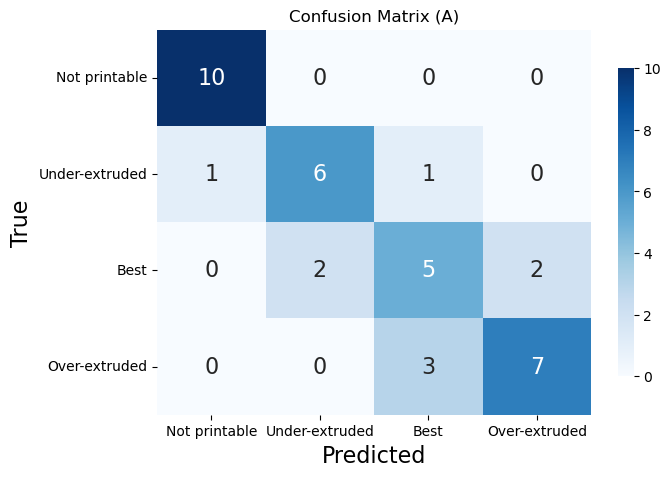

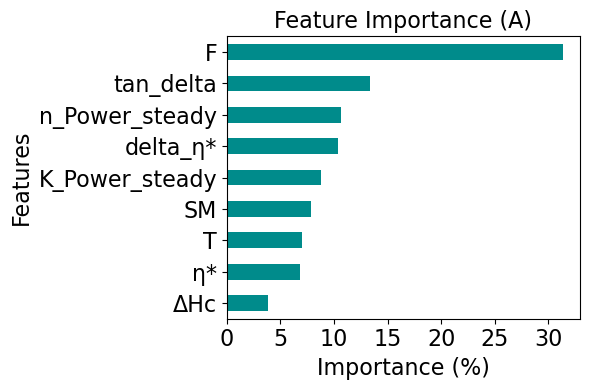


 Running grid search for feature set: B
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

 Feature Importance for B:
F: 26.94%
tan_delta: 11.83%
T5: 11.62%
delta_η*: 8.68%
n_Power_steady: 8.03%
T: 6.78%
SM: 6.32%
K_Power_steady: 6.16%
WL_Tp: 5.09%
η*: 4.70%
ΔHc: 3.86%
 Top 3 features for B:
1. F: 26.94%
2. tan_delta: 11.83%
3. T5: 11.62%


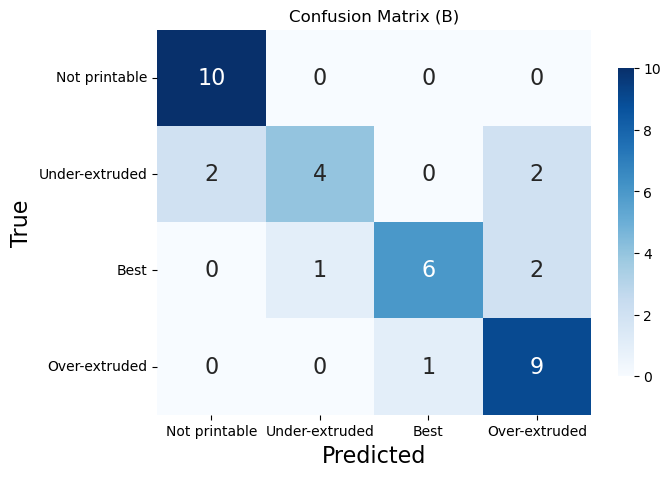

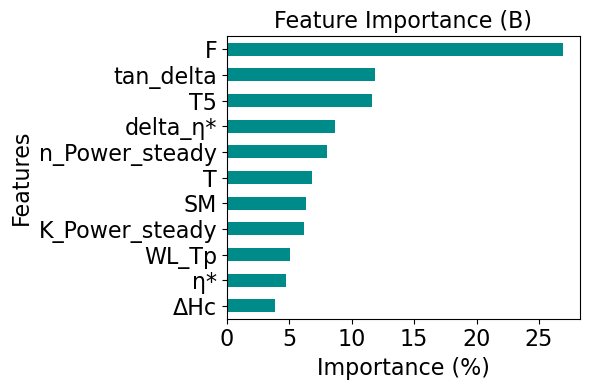


 Running grid search for feature set: C
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

 Feature Importance for C:
F: 30.94%
n_Power_steady: 15.73%
T5: 14.97%
T: 11.65%
K_Power_steady: 11.12%
WL_Tp: 9.12%
ΔHc: 6.48%
 Top 3 features for C:
1. F: 30.94%
2. n_Power_steady: 15.73%
3. T5: 14.97%


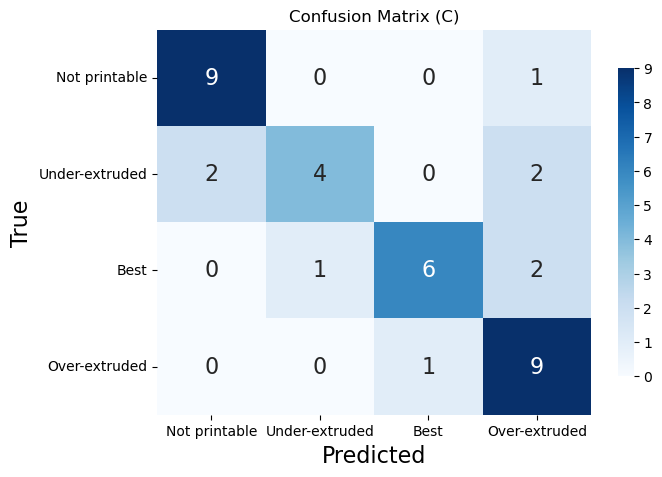

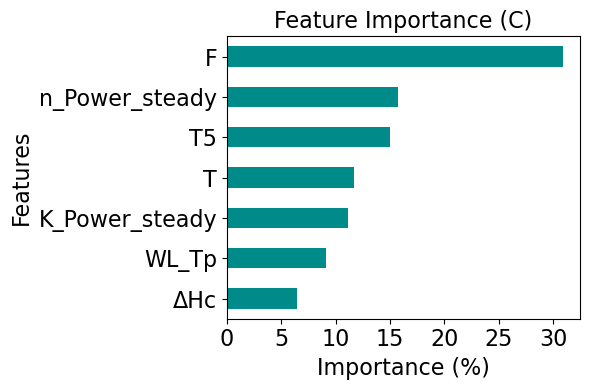


 Running grid search for feature set: D
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

 Feature Importance for D:
F: 29.67%
L_Carreau_steady: 15.36%
T5: 10.52%
T: 10.22%
WL_Tp: 10.20%
eta0_Carreau_steady: 8.47%
n_Carreau_steady: 6.61%
ΔHc: 5.41%
eta_inf_Carreau_steady: 3.53%
 Top 3 features for D:
1. F: 29.67%
2. L_Carreau_steady: 15.36%
3. T5: 10.52%


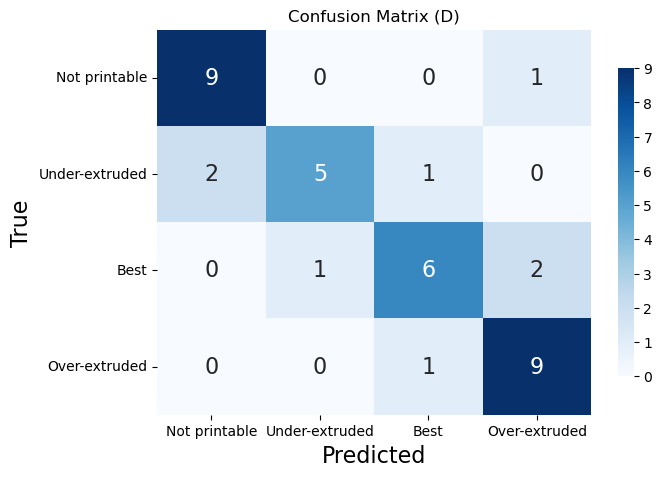

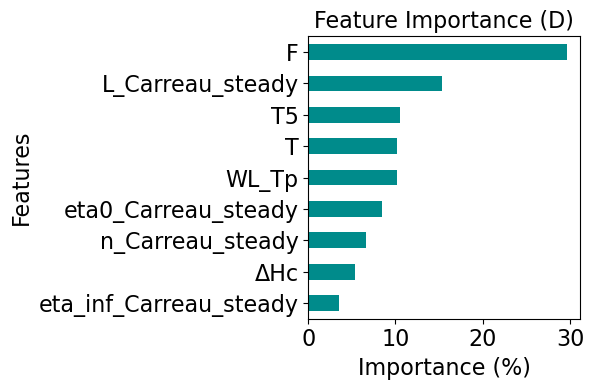


 Running grid search for feature set: E
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

 Feature Importance for E:
F: 34.20%
K_Power_capillary: 26.26%
WL_Tp: 9.96%
T: 9.68%
T5: 9.63%
n_Power_capillary: 5.53%
ΔHc: 4.75%
 Top 3 features for E:
1. F: 34.20%
2. K_Power_capillary: 26.26%
3. WL_Tp: 9.96%


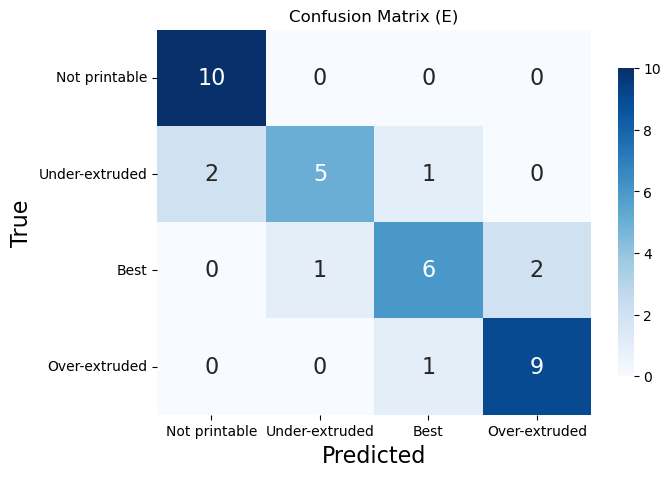

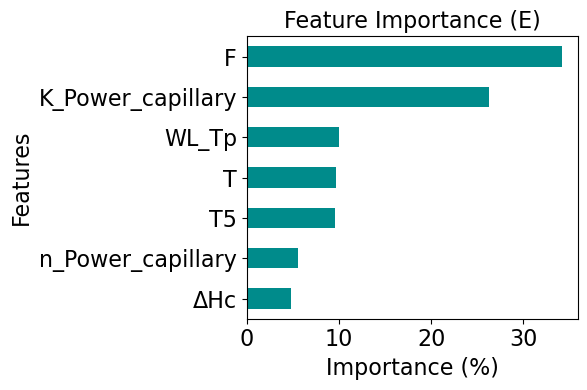


 Running grid search for feature set: F
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

 Feature Importance for F:
F: 29.92%
eta0_Carreau_capillary: 20.16%
T: 12.91%
WL_Tp: 11.33%
L_Carreau_capillary: 9.33%
T5: 7.23%
n_Carreau_capillary: 5.96%
ΔHc: 2.47%
eta_inf_Carreau_capillary: 0.68%
 Top 3 features for F:
1. F: 29.92%
2. eta0_Carreau_capillary: 20.16%
3. T: 12.91%


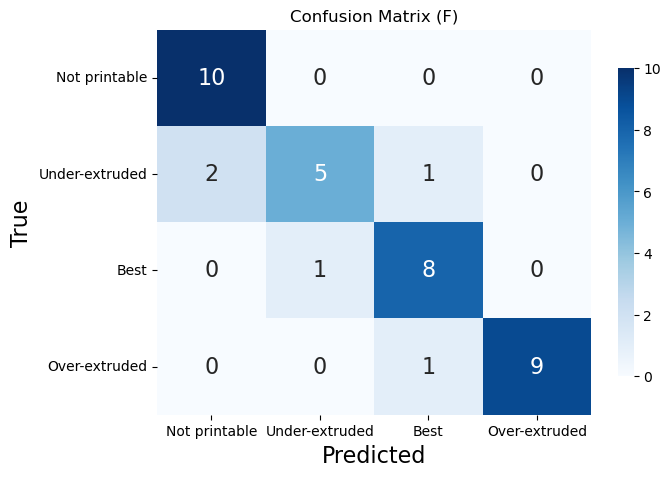

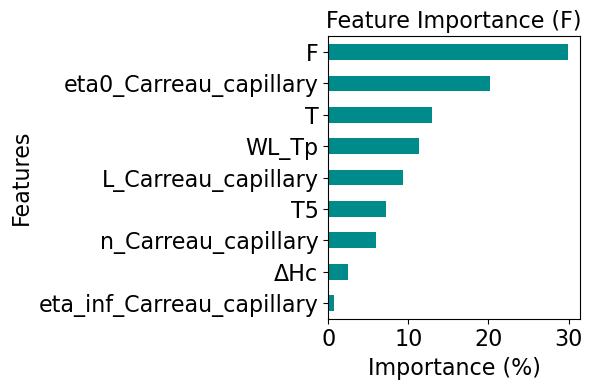


 Running grid search for feature set: X
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

 Feature Importance for X:
F: 31.55%
eta0_Carreau_capillary: 24.01%
T: 18.07%
L_Carreau_capillary: 15.00%
n_Carreau_capillary: 10.28%
eta_inf_Carreau_capillary: 1.09%
 Top 3 features for X:
1. F: 31.55%
2. eta0_Carreau_capillary: 24.01%
3. T: 18.07%


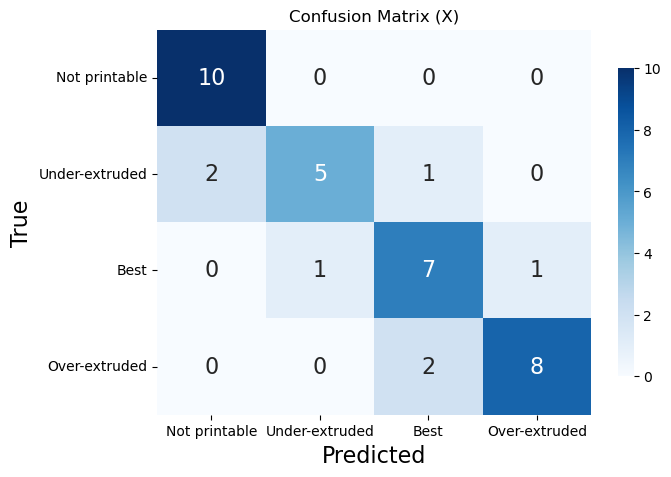

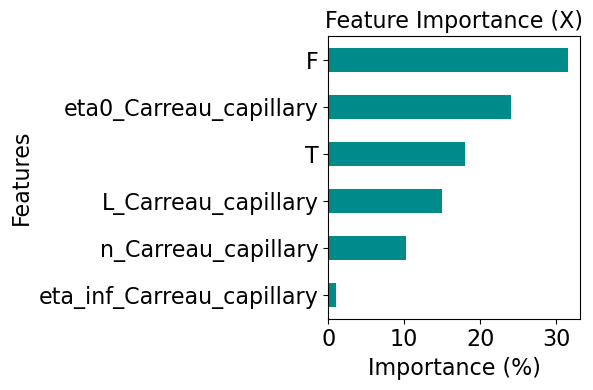


 Running grid search for feature set: G
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

 Feature Importance for G:
F: 31.90%
eta0_Carreau-Yasuda_capillary: 15.10%
L_Carreau-Yasuda_capillary: 13.01%
T: 10.64%
a_Carreau-Yasuda_capillary: 9.97%
WL_Tp: 7.70%
T5: 5.30%
eta_inf_Carreau-Yasuda_capillary: 2.77%
ΔHc: 2.54%
n_Carreau-Yasuda_capillary: 1.10%
 Top 3 features for G:
1. F: 31.90%
2. eta0_Carreau-Yasuda_capillary: 15.10%
3. L_Carreau-Yasuda_capillary: 13.01%


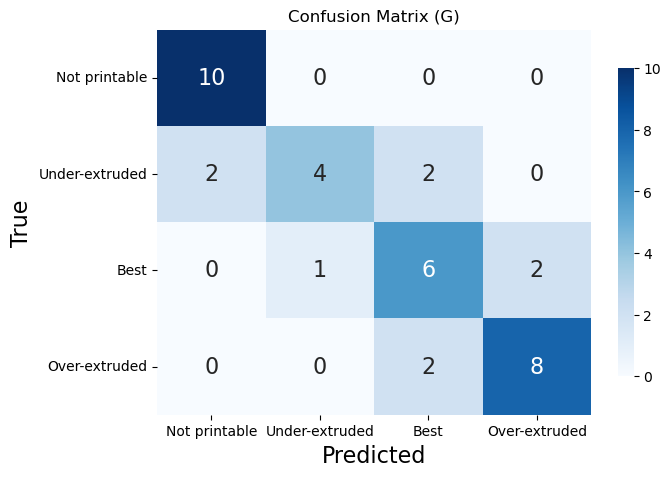

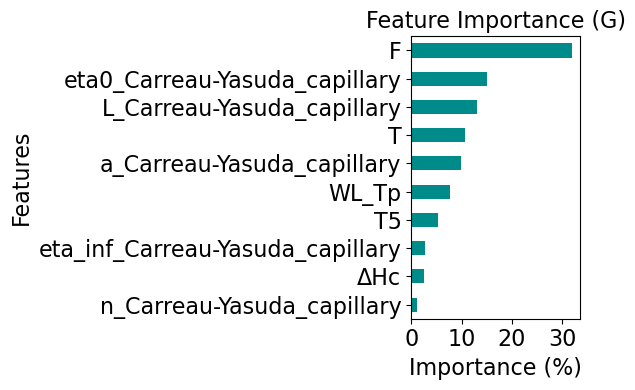


COMPREHENSIVE FEATURE SET COMPARISON SUMMARY

 PERFORMANCE METRICS:


,Feature Set,Accuracy,Macro F1,Weighted F1
0,A,0.7568,0.7487,0.7538
1,B,0.7838,0.7643,0.7727
2,C,0.7568,0.7431,0.7499
3,D,0.7838,0.7739,0.7789
4,E,0.8108,0.7966,0.8035
5,F,0.8649,0.8532,0.8610
6,X,0.8108,0.8006,0.8070
7,G,0.7568,0.7390,0.7486



 TOP FEATURES SUMMARY:


,Feature Set,Top Features
0,A,"F: 31.4%, tan_delta: 13.3%, n_Power_steady: 10.6%"
1,B,"F: 26.9%, tan_delta: 11.8%, T5: 11.6%"
2,C,"F: 30.9%, n_Power_steady: 15.7%, T5: 15.0%"
3,D,"F: 29.7%, L_Carreau_steady: 15.4%, T5: 10.5%"
4,E,"F: 34.2%, K_Power_capillary: 26.3%, WL_Tp: 10.0%"
5,F,"F: 29.9%, eta0_Carreau_capillary: 20.2%, T: 12.9%"
6,X,"F: 31.6%, eta0_Carreau_capillary: 24.0%, T: 18.1%"
7,G,"F: 31.9%, eta0_Carreau-Yasuda_capillary: 15.1%, L_Carreau-Yasuda_capillary: 13.0%"



 BEST HYPERPARAMETERS:


,Feature Set,Best Params
0,A,"{'max_depth': 9, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}"
1,B,"{'max_depth': 7, 'max_features': 7, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 250}"
2,C,"{'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}"
3,D,"{'max_depth': 7, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 500}"
4,E,"{'max_depth': 5, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}"
5,F,"{'max_depth': 7, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}"
6,X,"{'max_depth': 9, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}"
7,G,"{'max_depth': 5, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 500}"


In [7]:
#Call the classification
summary_results = grid_search_multiclass(df, feature_sets,
                                        )

<h2 style="color: #0066cc; font-size: 1.5em;">3.1 Plot the classification</h2>

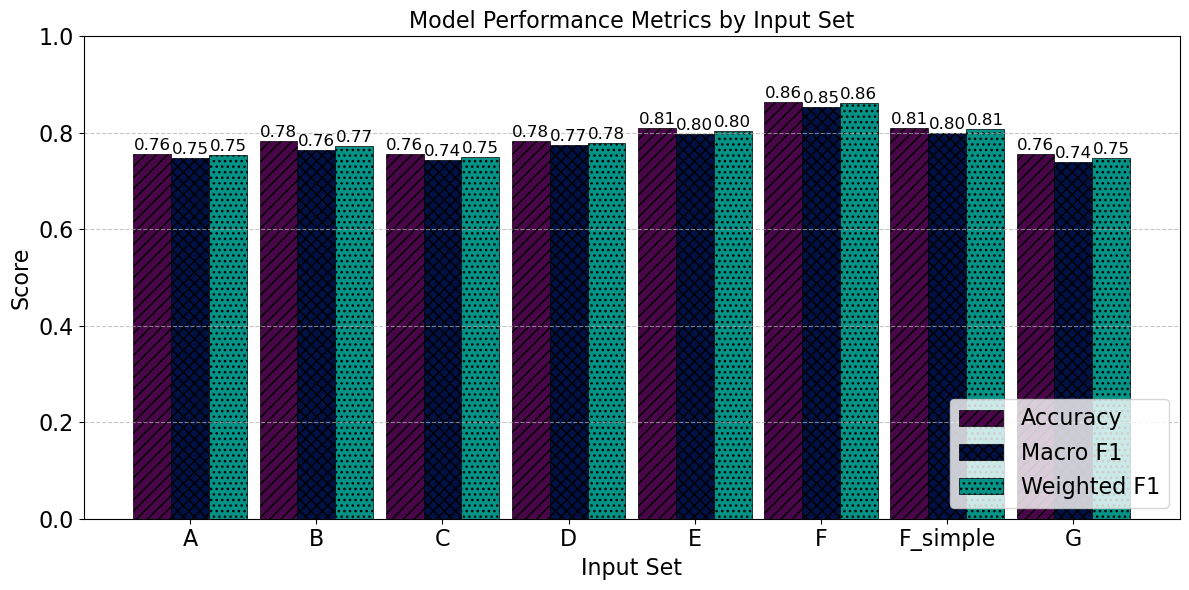

In [12]:
feature_sets = ['A', 'B', 'C', 'D', 'E', 'F', 'F_simple', 'G']
accuracy    = [0.7568, 0.7838, 0.7568, 0.7838, 0.8108, 0.8649, 0.8108, 0.7568]
macro_f1    = [0.7487, 0.7643, 0.7431, 0.7739, 0.7966, 0.8532, 0.8006, 0.7390]
weighted_f1 = [0.7538, 0.7727, 0.7499, 0.7789, 0.8035, 0.8610, 0.8070, 0.7486]

# Set up the plot
x = np.arange(len(feature_sets))
width = 0.3  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Create bars with textures/patterns
bars1 = ax.bar(x - width, accuracy, width, label='Accuracy', color='#490648', 
               hatch='///', edgecolor='black', linewidth=0.5)
bars2 = ax.bar(x, macro_f1, width, label='Macro F1', color='#001146', 
               hatch='xxx', edgecolor='black', linewidth=0.5)
bars3 = ax.bar(x + width, weighted_f1, width, label='Weighted F1', color='#029386', 
               hatch='...', edgecolor='black', linewidth=0.5)

# Add labels, title, and legend
ax.set_xlabel('Input Set', fontsize=16)
ax.set_ylabel('Score', fontsize=16)
ax.set_title('Model Performance Metrics by Input Set', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(feature_sets, fontsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.legend(loc='lower right', fontsize=16)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Set y-axis limit to better visualize differences
ax.set_ylim(0, 1)

# Add value labels on top of bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.002,
                f'{height:.2f}', ha='center', va='bottom', fontsize=12)

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)


plt.tight_layout()
plt.show()

<h2>3.2 Class based feature importance</h2>

In [13]:
def calculate_and_plot_class_importance(df, features_X, target_column='ΔW', 
                                      bins=None, labels=None, random_state=42):

    if bins is None:
        bins = [-1.0, -0.60, -0.105, 0.11, 0.6]
    if labels is None:
        labels = ['Not printable', 'Under-extruded', 'Best', 'Over-extruded']

    df['Class'] = pd.cut(df[target_column], bins=bins, labels=labels, include_lowest=True)
    
    results = []
    
    # Put the parameters for the feature set you want to analyze: in this case, it is feature set F
    best_params = { 
        'max_depth': 7,
        'max_features': 7,
        'min_samples_leaf': 1,
        'min_samples_split': 5,
        'n_estimators': 100
    }
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#F9A826']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, label in enumerate(labels):
        
        # Binary classification için
        y_binary = (df['Class'] == label).astype(int)
        X = df[features_X]
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_binary, test_size=0.15, stratify=y_binary, random_state=random_state
        )

        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Use the best parameters from gridsearch
        clf = RandomForestClassifier(
            class_weight='balanced',
            random_state=random_state,
            **best_params
        )
            
        clf.fit(X_train_scaled, y_train)
        
        # Permutation importance
        perm_importance = permutation_importance(
            clf, X_test_scaled, y_test, 
            n_repeats=10, random_state=random_state, n_jobs=-1
        )
        
        # Prepare the importance values
        importance_df = pd.DataFrame({
            'Feature': features_X,
            'Importance': perm_importance.importances_mean
        }).sort_values('Importance', ascending=True)
        
        # PLOT
        ax = axes[idx]
        
        bars = ax.barh(importance_df['Feature'], importance_df['Importance'], 
                      color=[colors[idx] if imp >= 0 else 'lightgray' for imp in importance_df['Importance']],
                      alpha=0.8, edgecolor='black', linewidth=0.8)
        
        # Print the values
        for i, (feature, importance) in enumerate(zip(importance_df['Feature'], importance_df['Importance'])):
            if importance >= 0:
                ax.text(importance + 0.003, i, f'{importance:.2f}', 
                       va='center',fontsize=16, color='darkblue')
            else:
                ax.text(importance - 0.003, i, f'{importance:.2f}', 
                       va='center', fontsize=16, color='red')
        
        ax.set_xlabel('Permutation Importance', fontsize=20)
        ax.set_ylabel('Features', fontsize=16)
        ax.tick_params(axis='y', labelsize=16)
        ax.tick_params(axis='x', labelsize=16)
        ax.set_title(f' {label}', fontsize=20, pad=15)
        ax.axvline(x=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
        ax.grid(axis='x', alpha=0.2, linestyle='--')
        ax.set_xlim(-0.05, 0.4)
        
        
        ax.spines[['top', 'right']].set_visible(False)
        
        
        results.append({
            'Class': label,
            'Importance_DF': importance_df,
            'Top_Feature': importance_df.iloc[-1]['Feature'],  # En yüksek importance
            'Top_Value': importance_df.iloc[-1]['Importance']
        })
        
        # Print the full feature importance for each class
        print(f"\n FULL FEATURE IMPORTANCE FOR: {label}")
        print("=" * 60)
        # Rank according to the importance values
        display_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)
        display_df['Rank'] = range(1, len(display_df) + 1)
        display_df = display_df[['Rank', 'Feature', 'Importance']]
        print(display_df.to_string(index=False))
        print("=" * 60)
    
    plt.suptitle(f'Class-Specific Feature Importance Analysis\nBest Parameters', 
                 fontsize=16, y=0.98)
    
    plt.tight_layout()
    plt.show()
    
  
    # Print the parameters used
    print(f"\nUSED PARAMETERS: {best_params}")
    
    return results




 FULL FEATURE IMPORTANCE FOR: Not printable
 Rank                   Feature  Importance
    1    eta0_Carreau_capillary    0.318919
    2                         F    0.075676
    3       L_Carreau_capillary    0.043243
    4                        T5    0.016216
    5                         T    0.013514
    6                     WL_Tp    0.000000
    7                       ΔHc    0.000000
    8 eta_inf_Carreau_capillary    0.000000
    9       n_Carreau_capillary   -0.002703

 FULL FEATURE IMPORTANCE FOR: Under-extruded
 Rank                   Feature  Importance
    1                         F    0.164865
    2                     WL_Tp    0.013514
    3       L_Carreau_capillary    0.010811
    4                         T    0.010811
    5                       ΔHc    0.000000
    6 eta_inf_Carreau_capillary    0.000000
    7       n_Carreau_capillary    0.000000
    8    eta0_Carreau_capillary   -0.005405
    9                        T5   -0.005405

 FULL FEATURE IMPORTANCE FOR

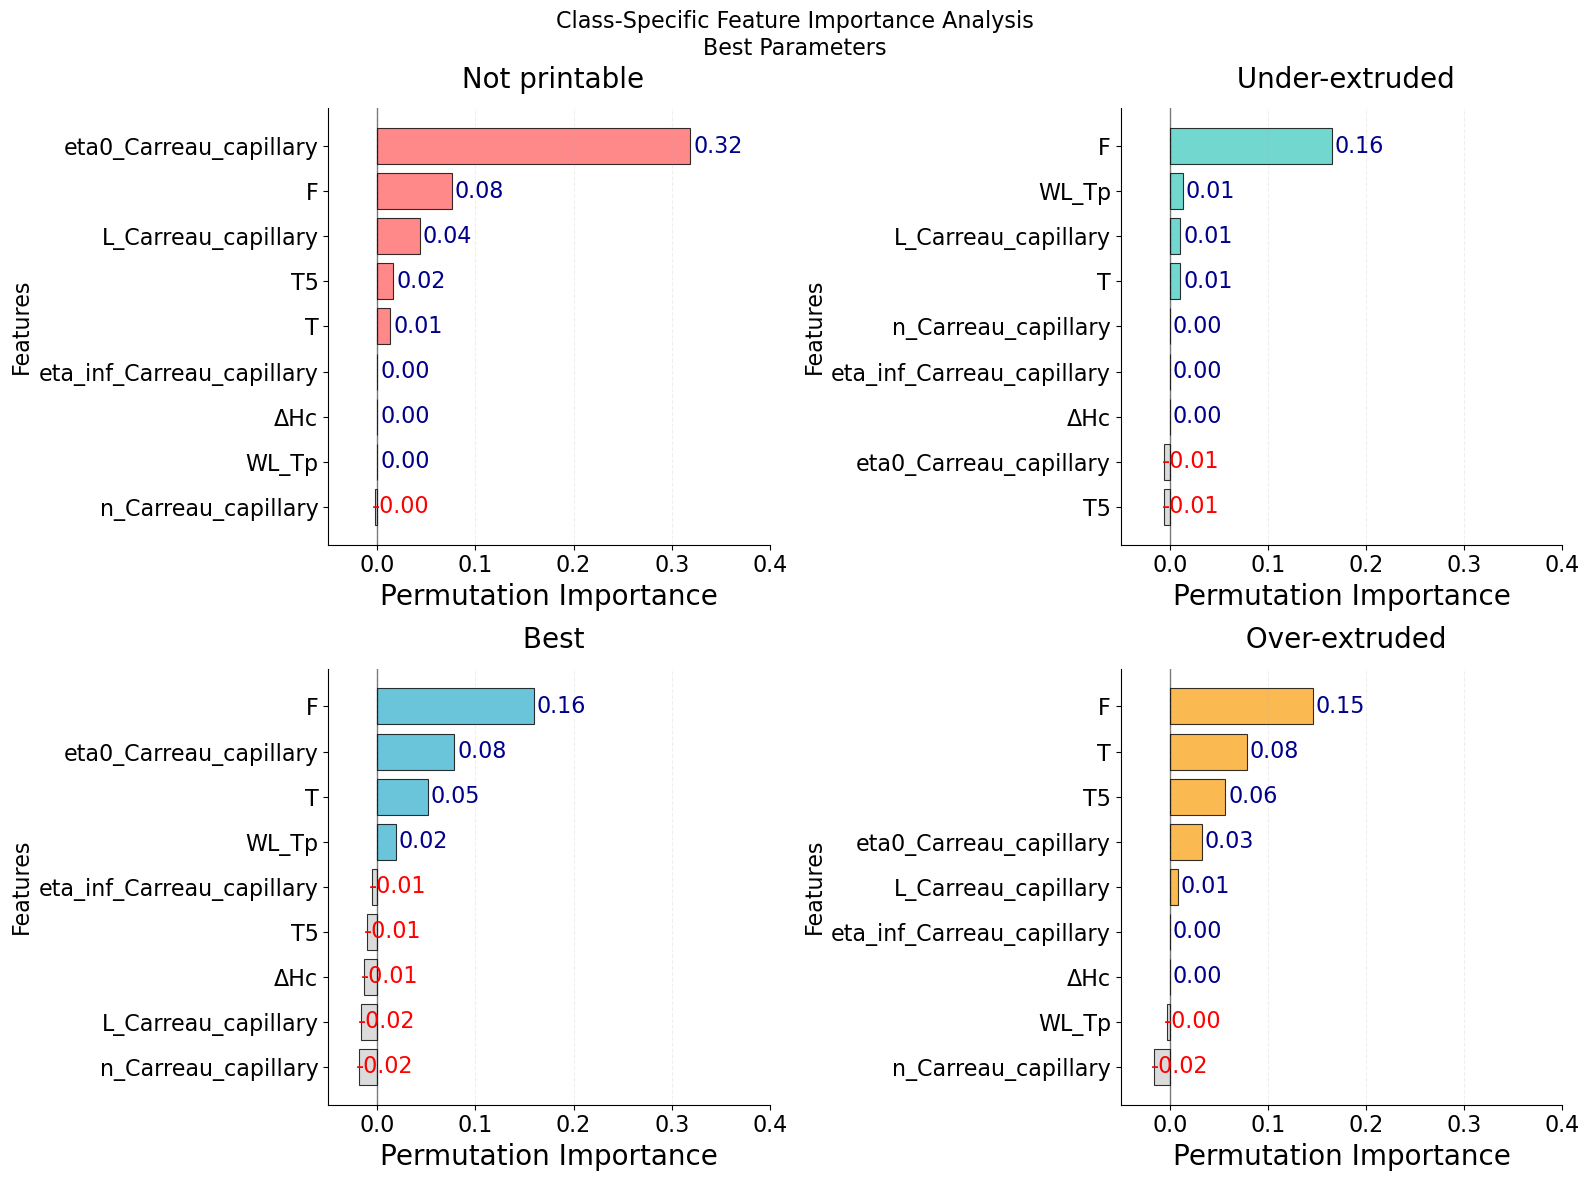


USED PARAMETERS: {'max_depth': 7, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [17]:
# call the class based feature importance
class_importance_results = calculate_and_plot_class_importance(
    df, 
    features_X=feature_sets['F'],  
    target_column='ΔW'
)

<h1>4. Regression of geometrical features for the best printable samples</h1>

In [27]:
## Dataframe of samples within the Best printability region
df_best = df[(df['ΔW'] >= -0.105) & (df['ΔW'] < 0.11)].copy()

In [31]:
#Chechk the range and variance of the data in this region
print("DATA RANGES IN BEST REGION (-0.1 ≤ ΔW ≤ 0.1)")
print("=" * 50)

print("ΔDi Statistics:")
print(f"Range: {df_best['ΔDi'].min():.3f} to {df_best['ΔDi'].max():.3f}")
print(f"Mean: {df_best['ΔDi'].mean():.4f}")
print(f"Std: {df_best['ΔDi'].std():.4f}")
print(f"Variance: {df_best['ΔDi'].var():.6f}")
print(f"Number of samples: {len(df_best['ΔDi'].dropna())}")

print("\n" + "-" * 40)

print("RA Statistics:")
print(f"Range: {df_best['RA'].min():.3f} to {df_best['RA'].max():.3f}")
print(f"Mean: {df_best['RA'].mean():.4f}")
print(f"Std: {df_best['RA'].std():.4f}")
print(f"Variance: {df_best['RA'].var():.6f}")
print(f"Number of samples: {len(df_best['RA'].dropna())}")

print("\n" + "=" * 50)
print("COMPARISON:")
print(f"RA Variance / ΔDi Variance ratio: {df_best['RA'].var() / df_best['ΔDi'].var():.1f}x")
print(f"RA Range / ΔDi Range ratio: {(df_best['RA'].max() - df_best['RA'].min()) / (df_best['ΔDi'].max() - df_best['ΔDi'].min()):.1f}x")

DATA RANGES IN BEST REGION (-0.1 ≤ ΔW ≤ 0.1)
ΔDi Statistics:
Range: -0.146 to -0.031
Mean: -0.0803
Std: 0.0399
Variance: 0.001589
Number of samples: 57

----------------------------------------
RA Statistics:
Range: 0.394 to 3.608
Mean: 1.1236
Std: 0.6828
Variance: 0.466241
Number of samples: 57

COMPARISON:
RA Variance / ΔDi Variance ratio: 293.4x
RA Range / ΔDi Range ratio: 28.0x


In [21]:
def regression(X, y, target, random_state, features=None, threshold=None, param_grid=None):
    """
    Perform grid search for Random Forest on given features and apply optional threshold.
    """
    if features is not None:
        X = X[features]

    if threshold is not None:
        col, value = threshold
        mask = y >= value
        X = X[mask]
        y = y[mask]

    # Scale features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Split the data
    X_trainset, X_testset, y_trainset, y_testset = train_test_split(
        X_scaled, y, test_size=0.15, random_state=random_state
    )

    # Random Forest model
    RF_model = RandomForestRegressor(random_state=42)

    # Grid search
    grid_search = GridSearchCV(
        estimator=RF_model,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=True
    )
    grid_search.fit(X_trainset, y_trainset.values.ravel())

    # Best model
    best_RF_model = grid_search.best_estimator_

    # Predictions
    y_pred = best_RF_model.predict(X_testset)
    y_predtrain = best_RF_model.predict(X_trainset)

    # Evaluation metrics
    test_r2 = best_RF_model.score(X_testset, y_testset)
    test_mae = mean_absolute_error(y_testset, y_pred)
    train_r2 = best_RF_model.score(X_trainset, y_trainset)
    train_mae = mean_absolute_error(y_trainset, y_predtrain)
    
    # T-test
    t_stat, p_value = stats.ttest_ind(y_testset, y_pred)

    # Print results
    print(f'Best hyperparameters for {target}:', grid_search.best_params_)
    print('Test R²:', test_r2)
    print('Test MAE:', test_mae)
    print('Train R²:', train_r2)
    print('Train MAE:', train_mae)
    print(f'T-test p-value for {target}:', p_value)

    # PERFORMANCE TABLE
    print(f"\n PERFORMANCE SUMMARY TABLE for {target}:")
    print("=" * 60)
    performance_data = {
        'Metric': ['Test R²', 'Test MAE', 'Train R²', 'Train MAE', 'T-test p-value'],
        'Value': [f"{test_r2:.4f}", f"{test_mae:.4f}", 
                 f"{train_r2:.4f}", f"{train_mae:.4f}", f"{p_value:.4f}"],
    }
    performance_df = pd.DataFrame(performance_data)
    print(performance_df.to_string(index=False))
    print("=" * 60)

    # Plot predictions
    plt.figure(figsize=(5, 5))
    plt.plot(y_trainset, y_predtrain, "o", color="blue", label="Training data")
    plt.plot(y_testset, y_pred, "o", color='red', label="Testing data")
    plt.legend(numpoints=1, fontsize=10, frameon=False)
    plt.ylabel(f"{target} - Prediction")
    plt.xlabel(f"{target} - Experiment")
    plt.show()

    # Feature importance
    f_impo = pd.Series(best_RF_model.feature_importances_ * 100, index=X.columns)
    summary_list = []
    # Feature importance plot
    plt.figure(figsize=(6, 4))
    f_impo.sort_values().plot(kind='barh')
    plt.xlabel('Feature Importance (%)')
    plt.title(f'{target} - Feature Importance')
    plt.show()

    return best_RF_model




🔎 Running grid search for feature set: A
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Best hyperparameters for ΔDi (A): {'max_depth': 8, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Test R²: 0.5838138634080816
Test MAE: 0.01855452515598146
Train R²: 0.8746322830361662
Train MAE: 0.009667621151446494
T-test p-value for ΔDi (A): 0.6244849640329964

 PERFORMANCE SUMMARY TABLE for ΔDi (A):
        Metric  Value
       Test R² 0.5838
      Test MAE 0.0186
      Train R² 0.8746
     Train MAE 0.0097
T-test p-value 0.6245


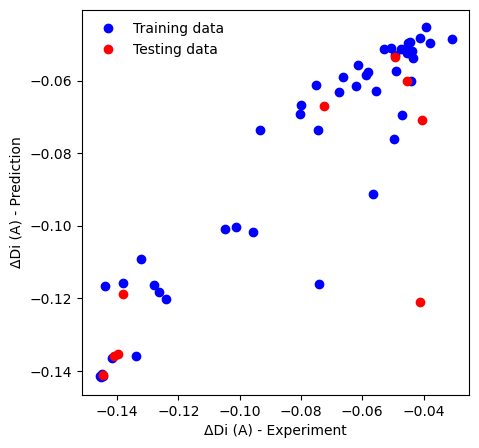

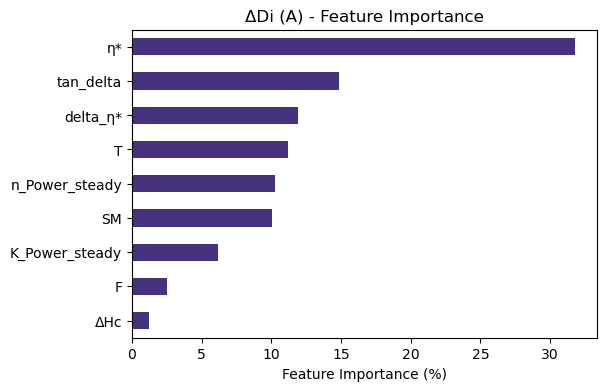


🔎 Running grid search for feature set: B
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Best hyperparameters for ΔDi (B): {'max_depth': 8, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Test R²: 0.57151193662441
Test MAE: 0.018013826335494733
Train R²: 0.887037599852184
Train MAE: 0.00926433949646282
T-test p-value for ΔDi (B): 0.6006330875501001

 PERFORMANCE SUMMARY TABLE for ΔDi (B):
        Metric  Value
       Test R² 0.5715
      Test MAE 0.0180
      Train R² 0.8870
     Train MAE 0.0093
T-test p-value 0.6006


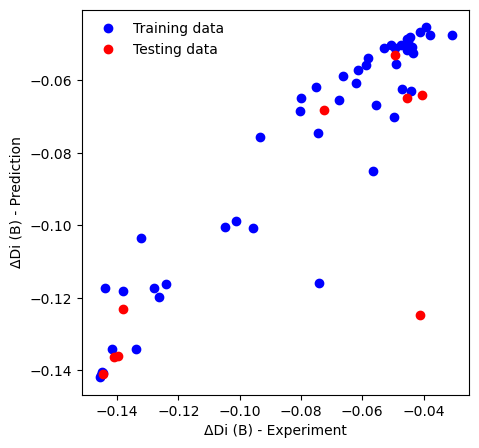

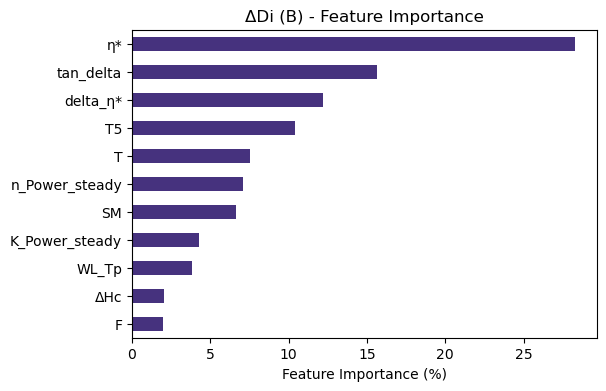


🔎 Running grid search for feature set: C
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Best hyperparameters for ΔDi (C): {'max_depth': 8, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Test R²: 0.8502102154093958
Test MAE: 0.015850361824761704
Train R²: 0.8566303146668686
Train MAE: 0.01119262931989909
T-test p-value for ΔDi (C): 0.8793808199095776

 PERFORMANCE SUMMARY TABLE for ΔDi (C):
        Metric  Value
       Test R² 0.8502
      Test MAE 0.0159
      Train R² 0.8566
     Train MAE 0.0112
T-test p-value 0.8794


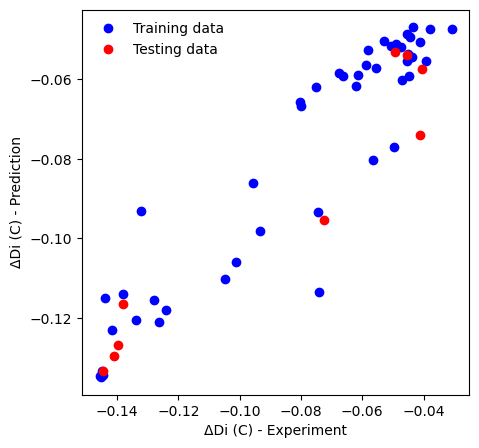

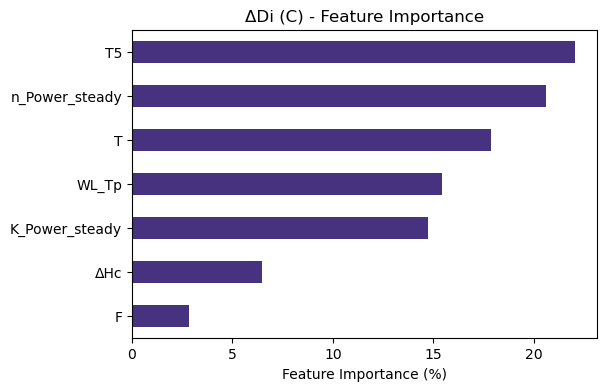


🔎 Running grid search for feature set: D
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Best hyperparameters for ΔDi (D): {'max_depth': 8, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Test R²: 0.8616426540748952
Test MAE: 0.01441964832421716
Train R²: 0.8398614950028667
Train MAE: 0.011415521777555691
T-test p-value for ΔDi (D): 0.9276200840823534

 PERFORMANCE SUMMARY TABLE for ΔDi (D):
        Metric  Value
       Test R² 0.8616
      Test MAE 0.0144
      Train R² 0.8399
     Train MAE 0.0114
T-test p-value 0.9276


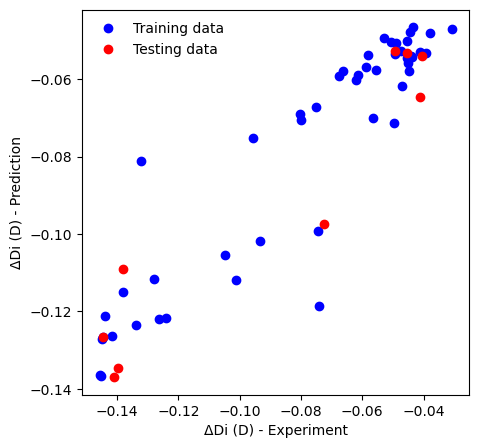

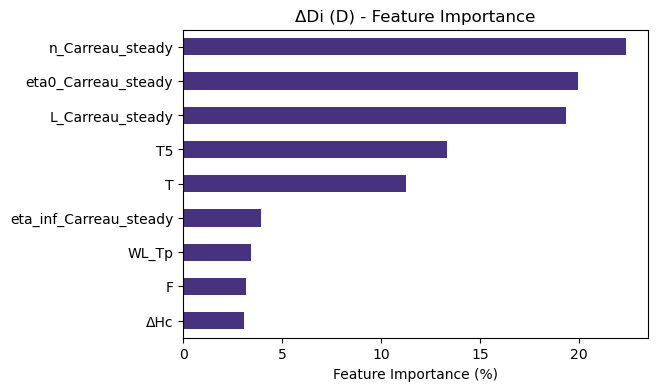


🔎 Running grid search for feature set: E
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Best hyperparameters for ΔDi (E): {'max_depth': 8, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Test R²: 0.8230908386005884
Test MAE: 0.016352749552823898
Train R²: 0.8577904541562575
Train MAE: 0.010553834681310903
T-test p-value for ΔDi (E): 0.8294853574870154

 PERFORMANCE SUMMARY TABLE for ΔDi (E):
        Metric  Value
       Test R² 0.8231
      Test MAE 0.0164
      Train R² 0.8578
     Train MAE 0.0106
T-test p-value 0.8295


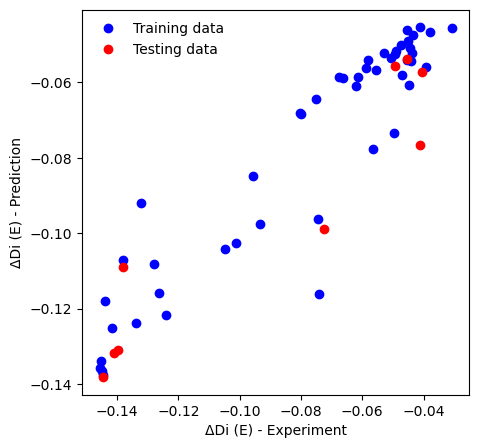

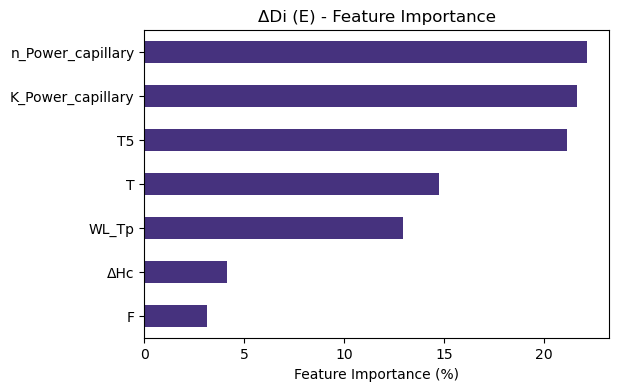


🔎 Running grid search for feature set: F
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Best hyperparameters for ΔDi (F): {'max_depth': 8, 'max_features': 9, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Test R²: 0.7525449898190886
Test MAE: 0.017286876284847284
Train R²: 0.84827742916116
Train MAE: 0.010824805382462508
T-test p-value for ΔDi (F): 0.8055061364429934

 PERFORMANCE SUMMARY TABLE for ΔDi (F):
        Metric  Value
       Test R² 0.7525
      Test MAE 0.0173
      Train R² 0.8483
     Train MAE 0.0108
T-test p-value 0.8055


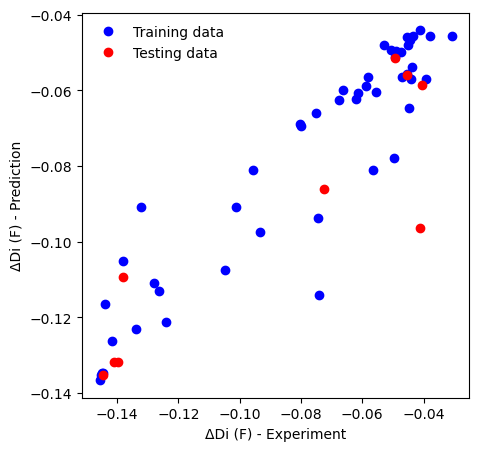

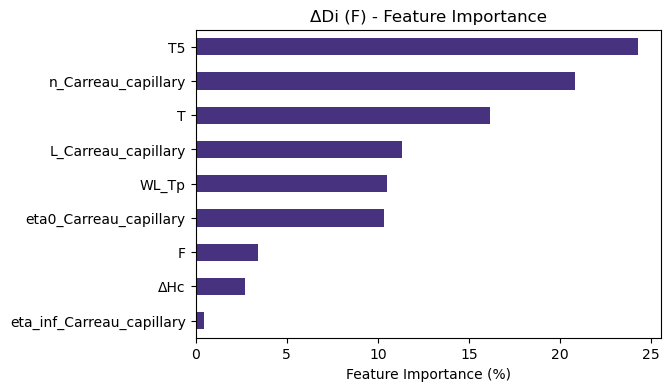


🔎 Running grid search for feature set: X
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Best hyperparameters for ΔDi (X): {'max_depth': 8, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Test R²: 0.7200812514991237
Test MAE: 0.01682757021372421
Train R²: 0.8230593102042637
Train MAE: 0.011658882070798937
T-test p-value for ΔDi (X): 0.7580149192099804

 PERFORMANCE SUMMARY TABLE for ΔDi (X):
        Metric  Value
       Test R² 0.7201
      Test MAE 0.0168
      Train R² 0.8231
     Train MAE 0.0117
T-test p-value 0.7580


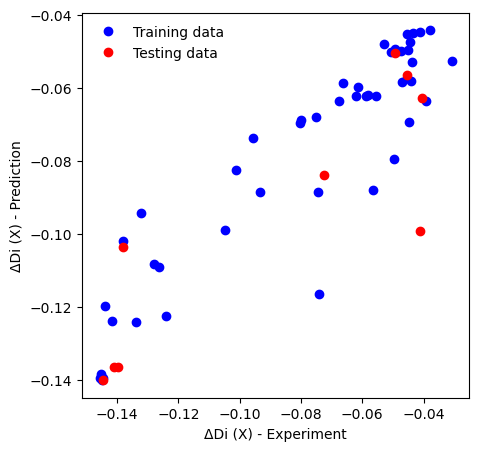

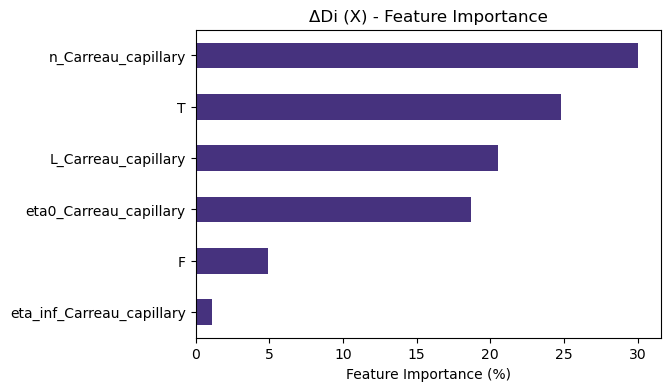


🔎 Running grid search for feature set: G
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Best hyperparameters for ΔDi (G): {'max_depth': 8, 'max_features': 9, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Test R²: 0.8616162229719697
Test MAE: 0.012683874850191556
Train R²: 0.8643255232818233
Train MAE: 0.010135282650600836
T-test p-value for ΔDi (G): 0.792418880293515

 PERFORMANCE SUMMARY TABLE for ΔDi (G):
        Metric  Value
       Test R² 0.8616
      Test MAE 0.0127
      Train R² 0.8643
     Train MAE 0.0101
T-test p-value 0.7924


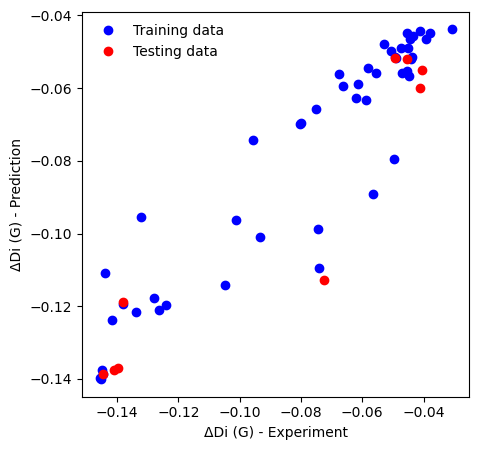

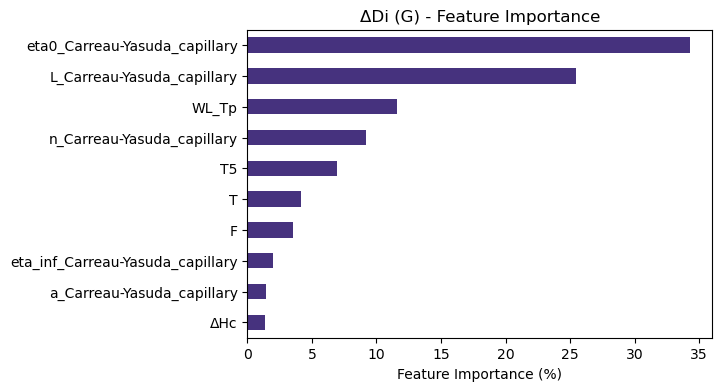


 FEATURE SET PERFORMANCE SUMMARY ΔDi:
Feature Set Test R² Test MAE Train R² Train MAE
          A  0.5993   0.0220   0.8347    0.0123
          B  0.6147   0.0220   0.8082    0.0134
          C  0.8417   0.0161   0.6686    0.0159
          D  0.8591   0.0145   0.8194    0.0126
          E  0.8198   0.0167   0.7148    0.0145
          F  0.7462   0.0178   0.7411    0.0142
          X  0.7201   0.0168   0.8231    0.0117
          G  0.8616   0.0128   0.7607    0.0129


In [22]:
results_summary_ΔDi = []

for name, features in feature_sets.items():
    print(f"\n🔎 Running grid search for feature set: {name}")
    
    # Get the model from the regression function
    regression_ΔDi_best = regression(
        X=df_best,
        y=df_best['ΔDi'],
        target=f'ΔDi ({name})',
        random_state=42,
        features=features,
        param_grid=param_grid_best
    )
    
    # PROPERLY get test/train metrics by redoing the train-test split
    X = df_best[features]
    y = df_best['ΔDi']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.15, random_state=42
    )
    
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Calculate REAL metrics
    train_r2 = regression_ΔDi_best.score(X_train_scaled, y_train)
    train_mae = mean_absolute_error(y_train, regression_ΔDi_best.predict(X_train_scaled))
    test_r2 = regression_ΔDi_best.score(X_test_scaled, y_test)
    test_mae = mean_absolute_error(y_test, regression_ΔDi_best.predict(X_test_scaled))
    
    results_summary_ΔDi.append({
        'Feature Set': name,
        'Test R²': f"{test_r2:.4f}",
        'Test MAE': f"{test_mae:.4f}",
        'Train R²': f"{train_r2:.4f}",
        'Train MAE': f"{train_mae:.4f}"
    })

# Print summary table
summary_df = pd.DataFrame(results_summary_ΔDi)
print("\n FEATURE SET PERFORMANCE SUMMARY ΔDi:")
print(summary_df.to_string(index=False))


 Running grid search for feature set: A
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Best hyperparameters for RA (A): {'max_depth': 8, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Test R²: 0.6607762927711529
Test MAE: 0.2584366268437523
Train R²: 0.8442032916963216
Train MAE: 0.17575259115972616
T-test p-value for RA (A): 0.748729587864113

 PERFORMANCE SUMMARY TABLE for RA (A):
        Metric  Value
       Test R² 0.6608
      Test MAE 0.2584
      Train R² 0.8442
     Train MAE 0.1758
T-test p-value 0.7487


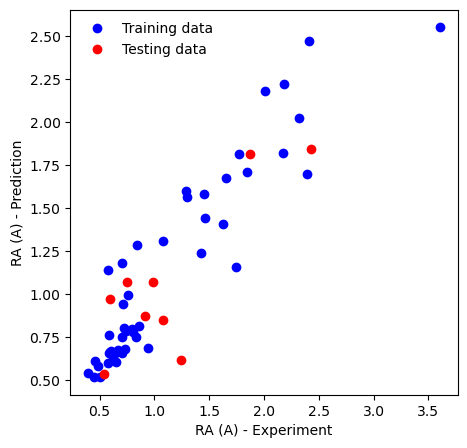

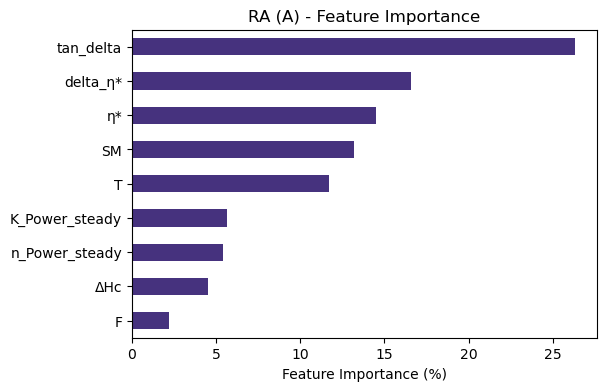


 Running grid search for feature set: B
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Best hyperparameters for RA (B): {'max_depth': 8, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Test R²: 0.6521380741397205
Test MAE: 0.2620501711362539
Train R²: 0.8515421422805072
Train MAE: 0.17362899748232427
T-test p-value for RA (B): 0.9263899596328032

 PERFORMANCE SUMMARY TABLE for RA (B):
        Metric  Value
       Test R² 0.6521
      Test MAE 0.2621
      Train R² 0.8515
     Train MAE 0.1736
T-test p-value 0.9264


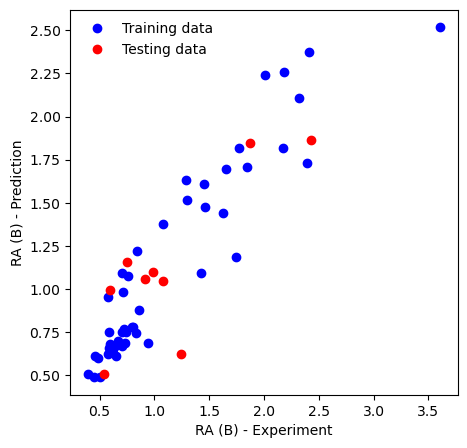

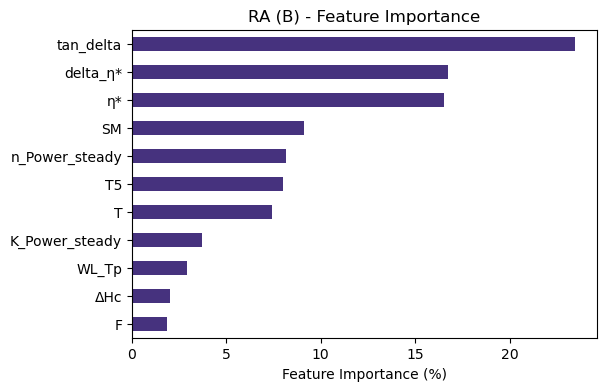


 Running grid search for feature set: C
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Best hyperparameters for RA (C): {'max_depth': 8, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Test R²: 0.5474295043333924
Test MAE: 0.32165774639375583
Train R²: 0.8236979858045835
Train MAE: 0.19354159295560827
T-test p-value for RA (C): 0.9234658167662727

 PERFORMANCE SUMMARY TABLE for RA (C):
        Metric  Value
       Test R² 0.5474
      Test MAE 0.3217
      Train R² 0.8237
     Train MAE 0.1935
T-test p-value 0.9235


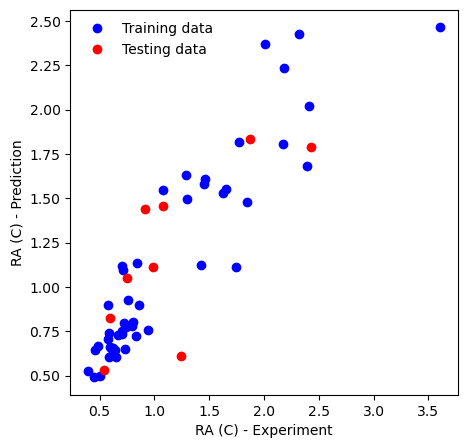

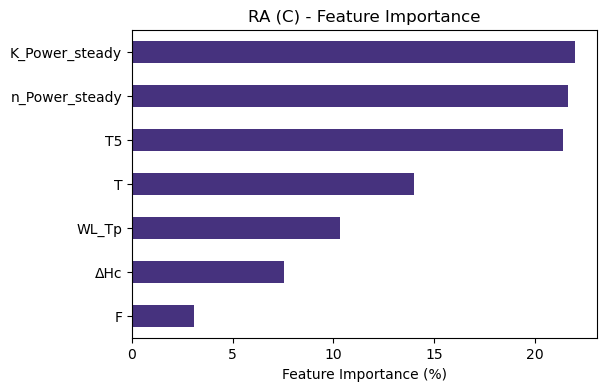


 Running grid search for feature set: D
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Best hyperparameters for RA (D): {'max_depth': 8, 'max_features': 9, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Test R²: 0.5053838793791988
Test MAE: 0.3350515720382751
Train R²: 0.8373102425292238
Train MAE: 0.1836185737736403
T-test p-value for RA (D): 0.8547975255271613

 PERFORMANCE SUMMARY TABLE for RA (D):
        Metric  Value
       Test R² 0.5054
      Test MAE 0.3351
      Train R² 0.8373
     Train MAE 0.1836
T-test p-value 0.8548


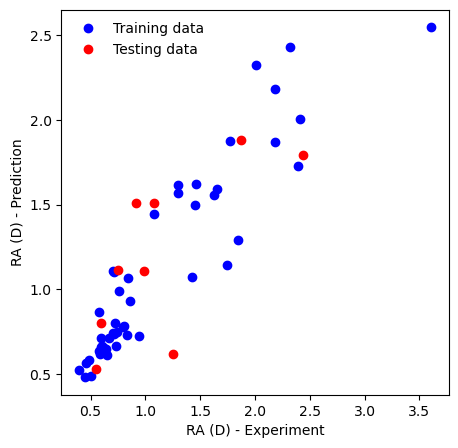

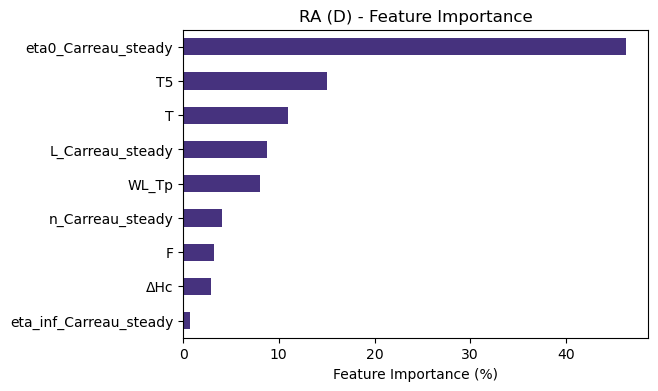


 Running grid search for feature set: E
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Best hyperparameters for RA (E): {'max_depth': 8, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 750}
Test R²: 0.5043391836026787
Test MAE: 0.3446898820648039
Train R²: 0.8132353065591983
Train MAE: 0.19077540702847517
T-test p-value for RA (E): 0.8630089407255368

 PERFORMANCE SUMMARY TABLE for RA (E):
        Metric  Value
       Test R² 0.5043
      Test MAE 0.3447
      Train R² 0.8132
     Train MAE 0.1908
T-test p-value 0.8630


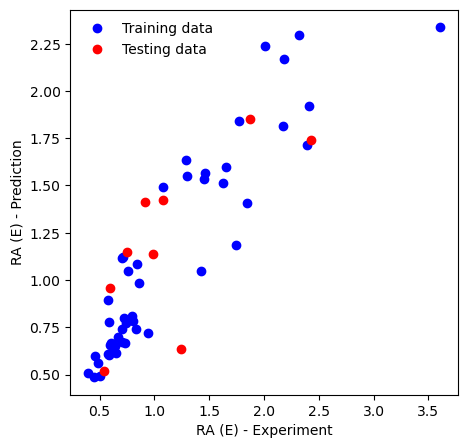

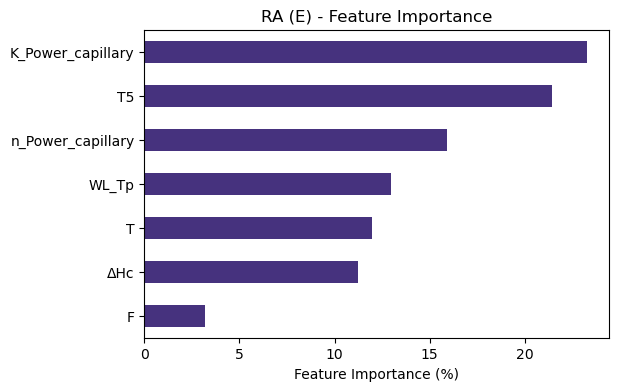


 Running grid search for feature set: F
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Best hyperparameters for RA (F): {'max_depth': 8, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Test R²: 0.2993937179492946
Test MAE: 0.40292081583711314
Train R²: 0.7934497234814251
Train MAE: 0.20894185203404772
T-test p-value for RA (F): 0.8188660387895834

 PERFORMANCE SUMMARY TABLE for RA (F):
        Metric  Value
       Test R² 0.2994
      Test MAE 0.4029
      Train R² 0.7934
     Train MAE 0.2089
T-test p-value 0.8189


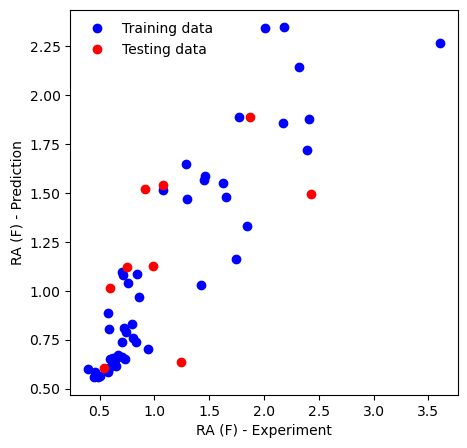

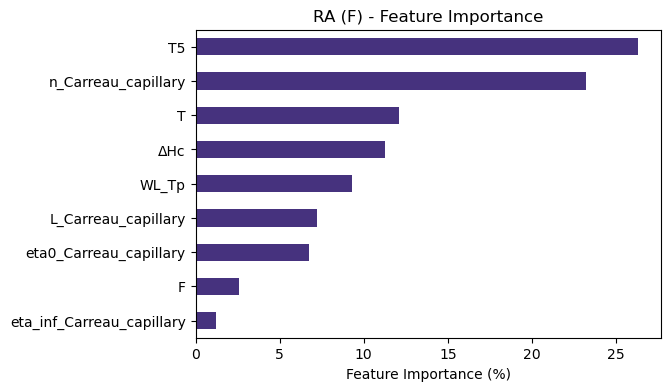


 Running grid search for feature set: X
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Best hyperparameters for RA (X): {'max_depth': 8, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 750}
Test R²: 0.4934089647754488
Test MAE: 0.3459905840351583
Train R²: 0.7636508606373287
Train MAE: 0.2176261435104215
T-test p-value for RA (X): 0.9821853645136046

 PERFORMANCE SUMMARY TABLE for RA (X):
        Metric  Value
       Test R² 0.4934
      Test MAE 0.3460
      Train R² 0.7637
     Train MAE 0.2176
T-test p-value 0.9822


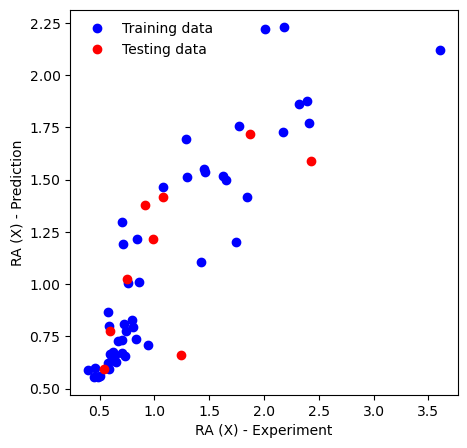

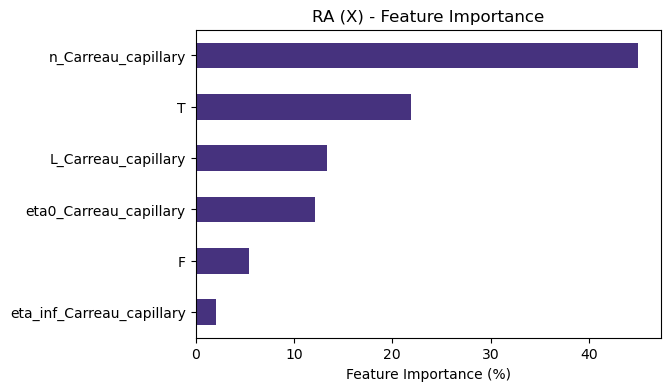


 Running grid search for feature set: G
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Best hyperparameters for RA (G): {'max_depth': 8, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Test R²: 0.30443839128296235
Test MAE: 0.3935158296648906
Train R²: 0.8194625643625506
Train MAE: 0.19399163019371238
T-test p-value for RA (G): 0.9030855508448881

 PERFORMANCE SUMMARY TABLE for RA (G):
        Metric  Value
       Test R² 0.3044
      Test MAE 0.3935
      Train R² 0.8195
     Train MAE 0.1940
T-test p-value 0.9031


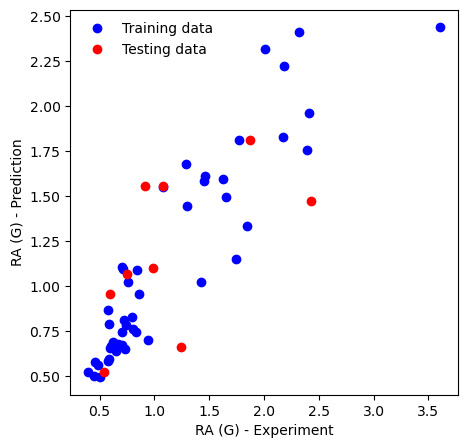

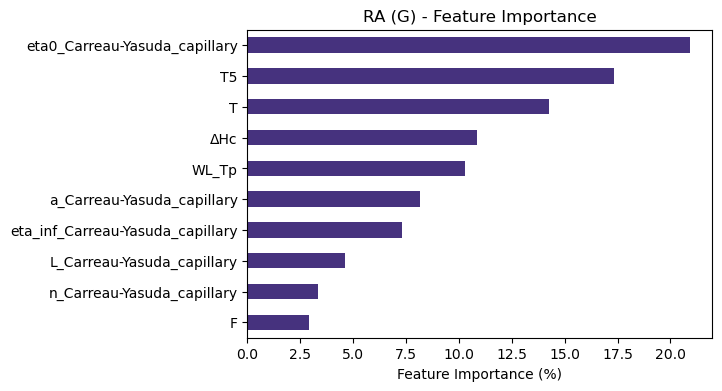


 FEATURE SET PERFORMANCE SUMMARY RA:
Feature Set Test R² Test MAE Train R² Train MAE
          A  0.7640   0.2192   0.7760    0.2237
          B  0.6661   0.2839   0.7651    0.2322
          C  0.5245   0.3353   0.7186    0.2493
          D  0.5307   0.3323   0.7490    0.2412
          E  0.4991   0.3579   0.6887    0.2620
          F  0.2882   0.4178   0.7074    0.2661
          X  0.4934   0.3460   0.7637    0.2176
          G  0.2679   0.4141   0.7280    0.2520


In [23]:
results_summary_RA = []

for name, features in feature_sets.items():
    print(f"\n Running grid search for feature set: {name}")
    
    # Get the model from the regression function
    regression_RA_best = regression(
        X=df_best,
        y=df_best['RA'],
        target=f'RA ({name})',
        random_state=42,
        features=features,
        param_grid=param_grid_best
    )
    
    # PROPERLY get test/train metrics by redoing the train-test split
    X = df_best[features]
    y = df_best['RA']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.15, random_state=42
    )
    
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Calculate REAL metrics
    train_r2 = regression_RA_best.score(X_train_scaled, y_train)
    train_mae = mean_absolute_error(y_train, regression_RA_best.predict(X_train_scaled))
    test_r2 = regression_RA_best.score(X_test_scaled, y_test)
    test_mae = mean_absolute_error(y_test, regression_RA_best.predict(X_test_scaled))
    
    results_summary_RA.append({
        'Feature Set': name,
        'Test R²': f"{test_r2:.4f}",
        'Test MAE': f"{test_mae:.4f}",
        'Train R²': f"{train_r2:.4f}",
        'Train MAE': f"{train_mae:.4f}"
    })

# Print summary table
summary_df = pd.DataFrame(results_summary_RA)
print("\n FEATURE SET PERFORMANCE SUMMARY RA:")
print(summary_df.to_string(index=False))

<h2>4.1 Plot the summary of all the regression results</h1>

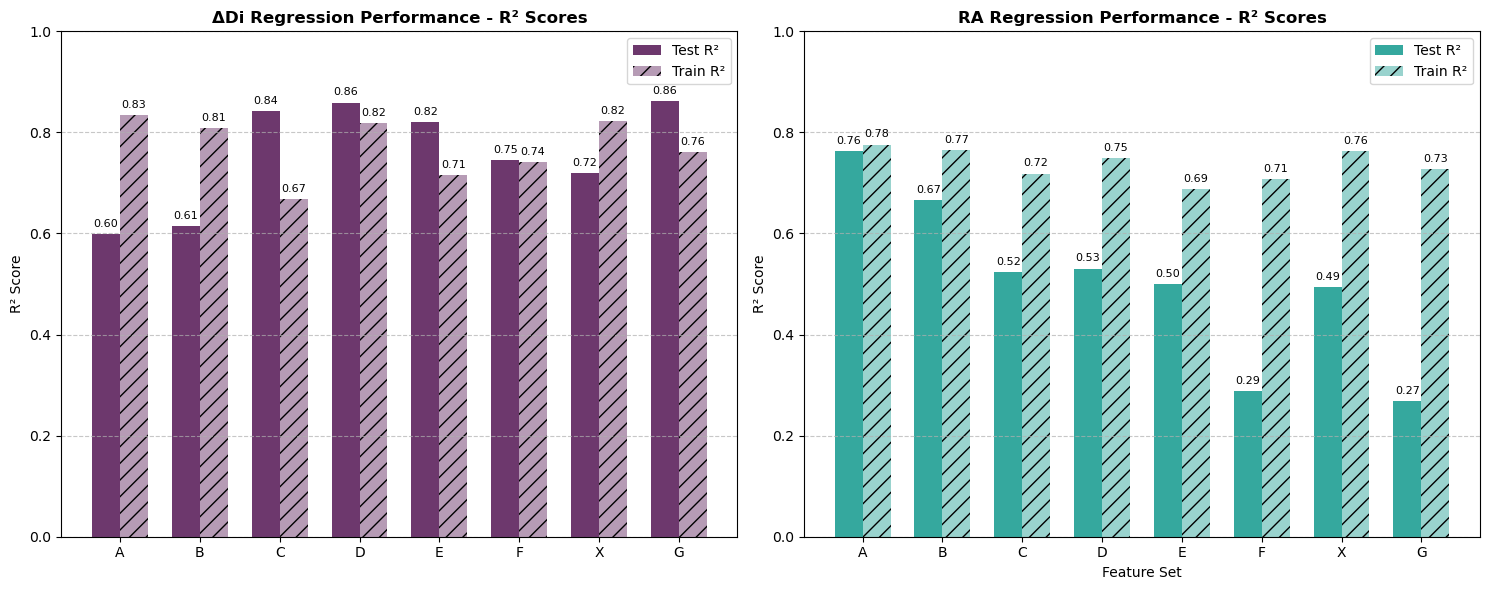

In [32]:
# Updated data from your summary tables
feature_sets = ['A', 'B', 'C', 'D', 'E', 'F', 'X', 'G']

# ΔDi performance data - CORRECTED
dDi_test_r2 = [0.5993, 0.6147, 0.8417, 0.8591, 0.8198, 0.7462, 0.7201, 0.8616]
dDi_test_mae = [0.0220, 0.0220, 0.0161, 0.0145, 0.0167, 0.0178, 0.0168, 0.0128]
dDi_train_r2 = [0.8347, 0.8082, 0.6686, 0.8194, 0.7148, 0.7411, 0.8231, 0.7607]
dDi_train_mae = [0.0123, 0.0134, 0.0159, 0.0126, 0.0145, 0.0142, 0.0117, 0.0129]

# RA performance data - CORRECTED
ra_test_r2 = [0.7640, 0.6661, 0.5245, 0.5307, 0.4991, 0.2882, 0.4934, 0.2679]
ra_test_mae = [0.2192, 0.2839, 0.3353, 0.3323, 0.3579, 0.4178, 0.3460, 0.4141]
ra_train_r2 = [0.7760, 0.7651, 0.7186, 0.7490, 0.6887, 0.7074, 0.7637, 0.7280]
ra_train_mae = [0.2237, 0.2322, 0.2493, 0.2412, 0.2620, 0.2661, 0.2176, 0.2520]


# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Set width of bars
width = 0.35
x = np.arange(len(feature_sets))

# Plot 1: ΔDi R² Scores
ax1.bar(x - width/2, dDi_test_r2, width, label='Test R²', color='#490648', alpha=0.8)
ax1.bar(x + width/2, dDi_train_r2, width, label='Train R²', color='#490648', alpha=0.4, hatch='//')
ax1.set_ylabel('R² Score')
ax1.set_title('ΔDi Regression Performance - R² Scores', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(feature_sets)
ax1.legend()
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_ylim(0, 1)

# Add value labels for ΔDi R²
for i, (test_val, train_val) in enumerate(zip(dDi_test_r2, dDi_train_r2)):
    ax1.text(i - width/2, test_val + 0.01, f'{test_val:.2f}', ha='center', va='bottom', fontsize=8)
    ax1.text(i + width/2, train_val + 0.01, f'{train_val:.2f}', ha='center', va='bottom', fontsize=8)

# Plot 2: RA R² Scores
ax2.bar(x - width/2, ra_test_r2, width, label='Test R²', color='#029386', alpha=0.8)
ax2.bar(x + width/2, ra_train_r2, width, label='Train R²', color='#029386', alpha=0.4, hatch='//')
ax2.set_xlabel('Feature Set')
ax2.set_ylabel('R² Score')
ax2.set_title('RA Regression Performance - R² Scores', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(feature_sets)
ax2.legend()
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.set_ylim(0, 1)

# Add value labels for RA R²
for i, (test_val, train_val) in enumerate(zip(ra_test_r2, ra_train_r2)):
    ax2.text(i - width/2, test_val + 0.01, f'{test_val:.2f}', ha='center', va='bottom', fontsize=8)
    ax2.text(i + width/2, train_val + 0.01, f'{train_val:.2f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()